In [133]:
epsilon = 0.1
gamma = .95
max_memory=100
memory = []

In [134]:
import pickle as pkl

def save(sth,name):
    fname = f"files/{name}"
    with open(fname,'wb') as f:
        pkl.dump(sth,f)


In [152]:
import numpy as np
from random import randint
from datetime import datetime
from buscaminas import MineSweeper as ms
from keras.models import model_from_json

def m_train(model,alto,ancho,bombas,epsilon=.1,cant_juegos=1,cant_mov_entrenar=10,verbose=False):    
    start_time = datetime.now()
    save = 0
    for juego in range(cant_juegos):
        #Creo Juego        
        game = ms(alto,ancho,bombas)
        duracion = 0
        cant_turnos = 0
        while not game.gameover:
            #Saco los bordes
            este_turno = np.copy(game.matriz_usuario.reshape(1,-1))          
            # Genereo proximo movimiento
            al_azar = (np.random.rand() <= epsilon)
            if not al_azar:                
                actions = np.argsort(model.predict(este_turno)[0]*-1)
            
            cant = 0
            boton = 0
            while cant==0:
                if al_azar:
                    action = randint(0,alto*ancho-1)
                else:
                    action = actions[boton]
                    boton+=1
                t1,t2 = game.get_loc(action) 
                cant = game.click(t1,t2)
                
            if game.gameover:
                if game.unclicked==0:
                    reward = 100
                    resultado = "gano"
                else:
                    reward = -10
                    resultado = "perdio"
            else:       
                reward = cant*2-1
            episode = [este_turno, 
                       action, 
                       reward, 
                       game.matriz_usuario.reshape(1,-1),
                       game.gameover]
            remember(episode)
            cant_turnos += 1

            # Train neural network model
            inputs, targets = get_data(model,data_size=cant_mov_entrenar)        
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=32,
                verbose=0,
            )
        dt = datetime.now() - start_time
        t = format_time(dt.total_seconds())            

        with open("progreso_bot.txt", "a+") as f:
            f.write(f"{game.unclicked},{resultado}\n")

        if verbose:
            print(f"Partida numero: {juego} con {game.unclicked} puntos y {cant_turnos} turnos, {t} y {resultado}")    
    if save==50:
        save = 0
        # serialize model to JSON
        model_json = model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        model.save_weights("model.h5")
        print("Saved model to disk")
    else:
        save+=1

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
def build_model(alto,ancho, lr=0.001):
    model = Sequential()
    model.add(Dense(alto*ancho, input_shape=(alto*ancho,)))
    #model.add(PReLU())
    model.add(Dense(alto*ancho))
    #model.add(PReLU())
    model.add(Dense(alto*ancho))
    model.compile(optimizer='adam', loss='mse')
    return model
def load_model():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    return loaded_model


In [153]:
alto = 5
ancho = 5
bombas = 3

In [154]:
model = build_model(alto,ancho)
#model = load_model()
model.compile(optimizer='adam', loss='mse')

100


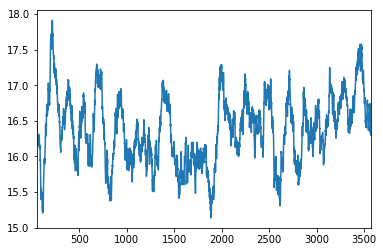

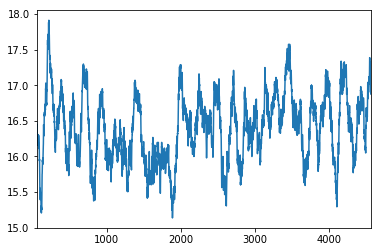

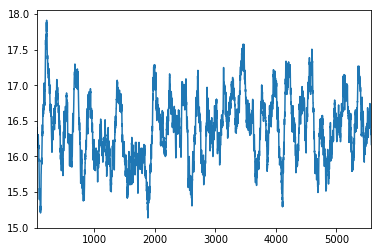

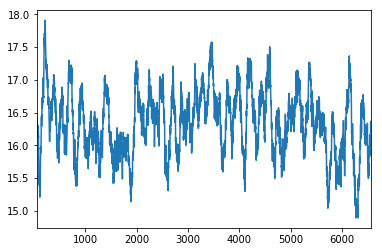

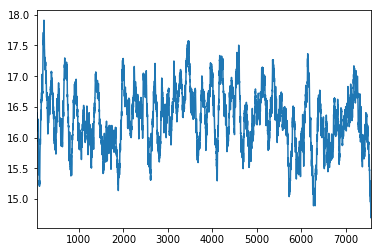

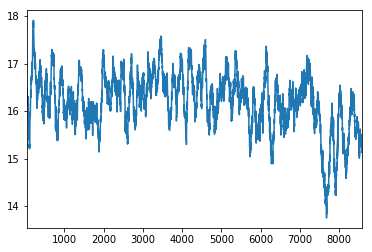

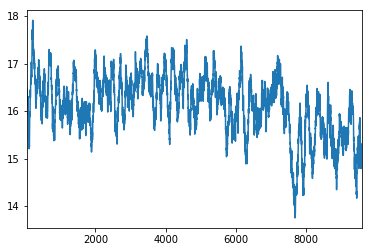

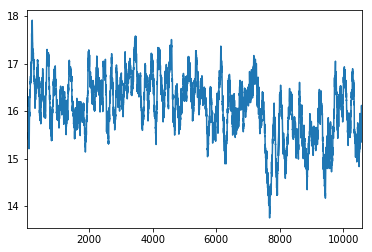

KeyboardInterrupt: 

In [218]:
print(len(memory))
m = 100
for k in range(10):
    m_train(model,alto,ancho,bombas,epsilon=.1,cant_juegos=1000,cant_mov_entrenar=10*k,verbose=False)
    replot(50)

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
def replot(n):
    df = pd.read_csv('progreso_bot.txt',header=None,names=['restantes','resultado'])

    acum = df.restantes.shift(n)
    for x in range(n*-1,n):
        acum += df.restantes.shift(x)
    (acum.dropna()/(n*2+1)).plot()
    plt.show()

In [159]:
from importlib import reload
import buscaminas
reload(buscaminas)
from buscaminas import MineSweeper as ms


In [210]:
#model = build_model(alto,ancho)
model = load_model()
model.compile(optimizer='adam', loss='mse')

In [214]:
play_one_game(model,ms(5,5,3),verbose_weights=False,verbose_game=True)

# # # # # 
# # # # # 
# # # # # 
# # # # 0 
# # # # # 

# # # # # 
# # # # # 
# # # # # 
1 # # # 0 
# # # # # 

# # # # # 
# # 1 # # 
# # # # # 
1 # # # 0 
# # # # # 

# # # 1 # 
# # 1 # # 
# # # # # 
1 # # # 0 
# # # # # 

# 0 # 1 # 
# # 1 # # 
# # # # # 
1 # # # 0 
# # # # # 

# 0 # 1 # 
# # 1 1 # 
# # # # # 
1 # # # 0 
# # # # # 

# 0 # 1 # 
# # 1 1 # 
# # # # # 
1 2 # # 0 
# # # # # 

# 0 # 1 # 
# # 1 1 # 
# # # # # 
1 2 2 # 0 
# # # # # 

# 0 # 1 # 
1 # 1 1 # 
# # # # # 
1 2 2 # 0 
# # # # # 

# 0 # 1 # 
1 # 1 1 B 
# # # # # 
1 2 2 # 0 
# # # # # 



In [164]:
def play_one_game(model,game,verbose_weights=False,verbose_game=False):
    k=0
    while not game.gameover:
        vec = model.predict(game.matriz_usuario.reshape(1,-1))[0]
        actions = np.argsort(vec*-1)
        pos = 0
        cant = 0
        while cant == 0:
            t1,t2 = game.get_loc(actions[pos])
            cant = game.click(t1,t2)
            pos+=1
              
        if verbose_weights:
            if cant != 0 :
                print(f"Movimiento: {k}\nScore: {game.unclicked}")
                game.pretty_weight(vec)
                print()
        if verbose_game:
            if cant != 0 :
                game.pretty_print(True)
                print()
        k+=1                        

# HASTA ACA

In [289]:
def play_one_game(model,bombas,verbose=False):
    game,player = game_matriz(alto,ancho,bombas)
    n_free_cells = alto*ancho-bombas
    game_over = False
    n_episodes = 0
    turnos_max = 0
    k=0
    win=False
    while not game_over:
        k+=1
        if turnos_max== 1000:
            break
        prev_envstate = np.reshape(np.array(player)[1:alto+1,1:ancho+1],newshape=(1,-1))
        actions = np.argsort(model.predict(prev_envstate)[0])

        pos = 0
        cant = 0
        while cant == 0:
            t1,t2 = get_click(actions[pos])            
            cant = click(t1,t2,game,player,alto,ancho)
            pos+=1
            
        if verbose:
            if cant != 0 :
                print(f"Movimiento: {k}\nScore: {n_free_cells-cant}")
                pretty_print(np.array(player)[1:alto+1,1:ancho+1])

        if cant==-1:
            game_over = True
        else:
            n_free_cells-=cant
        if n_free_cells==0:
            game_over = True
            win=True
        turnos_max+=1
    return win,turnos_max,n_free_cells-cant

In [296]:
play_one_game(model,10,verbose=True)

Movimiento: 1
Score: 889
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# 1 # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

(False, 3, 3)

# borrar cuando funke to2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

df = pd.DataFrame(stats)
df.columns = ['win','clicks','scores','iteracion']

        
grups = df.groupby('iteracion').agg({'scores':'mean','clicks':'mean','win':'mean'}).reset_index()
        
fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = ax.twinx()
par2 = ax.twinx()
#lo muevo 1.2 a la derecha
par2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = ax.plot(grups.iteracion, grups.clicks, "b-", label="clicks")
p2, = par1.plot(grups.iteracion, grups.scores, "r-", label="scores")
p3, = par2.plot(grups.iteracion, grups.win, "g-", label="win")

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#par1.set_ylim(0, 4)
#par2.set_ylim(1, 65)

ax.set_xlabel("eopchs")
ax.set_ylabel("clicks")
par1.set_ylabel("scores")
par2.set_ylabel("win")

ax.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

ax.legend(lines, [l.get_label() for l in lines])

plt.show()


In [271]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(stats)
df.columns = ['win','clicks','scores','iteracion']
print(df.clicks.mean())
print(df.scores.mean())
print(df[df.win].shape[0],df.shape[0],df[df.win].shape[0]/df.shape[0])
grups = df.groupby('iteracion').agg({'scores':'mean','clicks':'mean','win':'mean'})
grups.plot()
#df[df.clicks>10].clicks.hist(bins=100)
#plt.show()
#df.scores.hist(bins=200)
#plt.show()

2

In [ ]:
def qtrain(model,n_epoch=10,batch_size=100,verbose=False):
    global epsilon,alto,ancho,bombas
    hsize = alto*ancho//2   # history window size
    start_time = datetime.datetime.now()
    for epoch in range(n_epoch):
        loss = 0.0
        game,player = game_matriz(alto,ancho,bombas)
        n_free_cells = alto*ancho-bombas
        game_over = False
        n_episodes = 0
        while not game_over:
            prev_envstate = np.reshape(np.array(player)[1:alto+1,1:ancho+1],newshape=(1,-1))
            # Get next action
            if np.random.rand() < epsilon:
                action = randint(0,alto*ancho-1)
            else:
                action = np.argmax(model.predict(prev_envstate))

            # Apply action, get reward and new envstate
            t1,t2 = get_click(action) 
            cant = click(t1,t2,game,player,alto,ancho)
            while cant==0:
                action = randint(0,alto*ancho-1)
                t1,t2 = get_click(action) 
                cant = click(t1,t2,game,player,alto,ancho)
            if cant==-1:
                game_over = True
                reward = -100
            else:
                n_free_cells-=cant
                reward=1
            if n_free_cells==0:
                game_over = True
                reward = 100
            
            if cant == 0:
                reward = -.2
            # Store episode (experience)
            
            episode = [prev_envstate, action, reward, np.reshape(np.array(player)[1:alto+1,1:ancho+1],newshape=(1,-1)), game_over]
            remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = get_data(model,data_size=batch_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        if verbose:
            print(f"epoch {epoch} {t}")    
